### DSGE Problem Set Part 1

In [64]:
import scipy.optimize as opt
import numpy as np
import time
from matplotlib import pyplot as plt

%matplotlib inline

### Exercise 5

In [10]:
#Lets solve our algebraic expression for kbar
alpha = .4
gamma = 2.5
beta = .98
delta = .1
z = 0
tau = .05

print("Algebraic Kbar = ",alpha**(1/(1-alpha)) / (delta + (1 - beta)/(beta*(1-tau))) **(1/(1-alpha)))

Algebraic Kbar =  7.287497950692988


In [16]:
def steadystate5(k):
    w = (1-alpha)*k**(alpha)
    r = alpha*k**(alpha-1)
    T = tau*(w + (r - delta)*k)
    c = (1-tau)*(w + (r-delta)*k) + T
    val = c**(-gamma) - beta*c**(-gamma)*((r - delta)*(1-tau) + 1)
    return val

kbar = opt.root(steadystate5, 5)
print("Computational Kbar = ", kbar.x)

Computational Kbar =  [ 7.28749795]


### Exercise 6

In [32]:
#Exogenous Parameters
alpha = .4
gamma = 2.5
xi = 1.5
a = .5
beta = .98
delta = .1
z = 0
tau = .05

def steadystate6(klvec):
    k, l = klvec
    w = (1-alpha)*k**(alpha)*l**(-alpha)
    r = alpha*k**(alpha-1)*l**(1-alpha)
    T = tau*(w*l + (r - delta)*k)
    c = (1-tau)*(w*l + (r-delta)*k) + T
    val1 = c**(-gamma) - beta*c**(-gamma)*((r - delta)*(1-tau) + 1)
    val2 = w*(1-tau)*c**(-gamma) - a*(1 -l)**(-xi)
    return (val1, val2)

kbar, lbar = opt.root(steadystate6, (5,0.5)).x
print("Computational Kbar = ", kbar, ", Computational Lbar = ", lbar)

# Lets back out all other steady state values
wbar = (1 -alpha)*kbar**(alpha)*lbar**(-alpha)
rbar = alpha*kbar**(alpha -1)*lbar**(1-alpha)
Tbar = tau*(wbar*lbar + (rbar - delta)*kbar)
cbar = (1-tau)*(wbar*lbar + (rbar - delta)*kbar)
Ibar = delta*kbar # Investment to keep k at steady state
Ybar = kbar**(alpha)*lbar**(1-alpha) 
print("wbar = ", wbar, "\nrbar = ", rbar, "\nTbar = ", Tbar, "\ncbar = ", cbar, "\nIbar = ", Ibar, "\nYbar = ", Ybar)

Computational Kbar =  4.22522902679 , Computational Lbar =  0.579791453168
wbar =  1.32795276835 
rbar =  0.121482277121 
Tbar =  0.0430351603078 
cbar =  0.817668045848 
Ibar =  0.422522902679 
Ybar =  1.28322610883


### Exercise 8

We will code up a solution to the Brock and Mirman model using Value Function Iteration. In particular, we discretize the state space to a grid of 25 points from $0.5 \bar{K}$ to $1.5 \bar{K}$. We also discretize our AR(1) Process using the Rouwenhorst method to obtain a grid of 25 points.

In [63]:
# Initial Parameters
alpha = .35
beta = .98
rho = .95
sigma = .02

params = alpha, beta, rho, sigma

# Compute steady state capital
kbar = (alpha * beta)**(1/(1-alpha))

# Generate Grid for Capital
kvec = np.linspace(0.5*kbar, 1.5*kbar, 25)

# Generate Grid for Markov Process
import ar1_approx as ar1

pi, zvec = ar1.rouwen(rho, 0, 5*sigma/12, 25)

In [57]:
def VFI(kvec, zvec, prob, params, tol=1e-6,maxiter=3000):
    '''
    kvec = grid of capital values
    zvec = grid of shock realisations
    prob = transition probability matrix
    params = household parameters
    tol = tolerance of VFI
    maxiter = maximum iterations
    
    Purpose: Compute value function and policy function through VFI
    for Brock Mirman Model'''
    
    alpha, beta, rho, sigma = params
    size_k = kvec.shape[0]
    size_z = zvec.shape[0]
    VFtol = tol
    VFdist = 7.0
    VFmaxiter = maxiter
    V = np.zeros((size_k, size_z))  # k by z size matrix
    Vmat = np.zeros((size_k, size_k, size_z))  # initialize Vmat matrix
    VFiter = 1
    
    
    start_time = time.clock()
    
    while VFdist > VFtol and VFiter < VFmaxiter:
        TV = V
        for i in range(size_k):  # loop over k
            for j in range(size_k):  # loop over k'
                for k in range(size_z): # Loop over z
                    Vmat[i, j, k] =  np.log(np.exp(zvec[k])*kvec[i]**alpha - kvec[j]) + beta * V[j,:].dot(prob[:,k])
        V = Vmat.max(axis=1)  # apply max operator to Vmat (to get V(k))
        PF = np.argmax(Vmat, axis=1)  # find the index of the optimal k'
        VFdist = (np.absolute(V - TV)).max()  # check distance between value
        # function for this iteration and value function from past iteration
        VFiter += 1
        #print("Error",VFdist)

    VFI_time = time.clock() - start_time
    if VFiter < VFmaxiter:
        print('Value function converged after this many iterations:', VFiter)
    else:
        print('Value function did not converge')
    print('VFI took ', VFI_time, ' seconds to solve')
        
    return V, PF  # solution to the functional equation
    

In [58]:
V, PF = VFI(kvec, zvec, pi, params, tol=1e-4)

Value function converged after this many iterations: 458
VFI took  149.68567862110626  seconds to solve


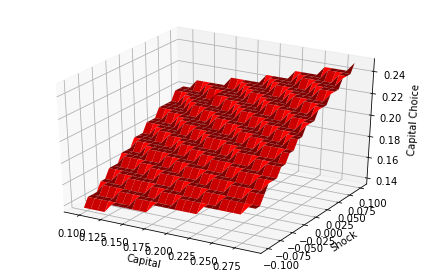

In [71]:
# Lets generate our 3d plot.
from mpl_toolkits.mplot3d import Axes3D

kgrid, zgrid = np.meshgrid(kvec, zvec)
kprime = kvec[PF]

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.plot_surface(kgrid, zgrid, kprime, rstride = 1, cstride = 1, color='r')
ax1.set_xlabel('Capital')
ax1.set_ylabel('Shock')
ax1.set_zlabel('Capital Choice')
plt.tight_layout()
plt.show()

As we can see, this graph does indeed match our policy function, which says that optimal capital policy choice is increasing in both current capital and the realization of the shock.